# Don't get confused: The importance of filtering for canonical protein isoforms during integrative analysis of phosphoproteomics data

Justus Florian Gräf - 26.01.2022

The following code allows to annoate a MaxQuant derived phosphoproteomics dataset with the canonical isoform information for each phosphorylation site. Furthermore, functional score and disease annotations are mapped to the phosphorylation sites and effects of canonical filtering are evaluated.



### Importing libraries and set working directory

In [1]:
# import all nescessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math

In [2]:
# set working directory
%cd ..

C:\Users\Justus\Documents\CPH\APPBS\01_PROJECT


## Core functions
### Retrieving canonical protein isoforms from UniProt dataset

In [3]:
# define function with variable "uniprot_file" that should be a filename (with path) of a fasta file containing canonical isoforms
def get_isoforms(uniprot_file):
    
    # creating empty list
    isoforms = []
    
    # open uniprot file as "uni" and execute following for loop
    with open(uniprot_file) as uni:
        
        # for loop to go loop through each line in uniprot fasta file
        for line in uni:
            # all lines that start with a fasta description symbol (>) and the "sp" dataset identifier
            if line.startswith(">sp"):
                
                # split the fasta description in multiple elements and store in list
                fasta_names = line.split(sep="|")
                
                # second element in fasta descriptions is the uniprot ID which is stored as "names"
                names = fasta_names[1]
                
                # the empty isoforms list is appended by each uniprot ID resulting in a list with all canoncial uniprot IDs
                isoforms.append(names)
    
    return isoforms

        

### Map canonical phosphorylation sites to MaxQuant-derived phosphoproteomics dataset

In [4]:

# define function with variables filename (for MQ derived dataset) and isoforms list that was created with get_isoforms() function
def map_canonical(filename, isoforms):
    
    # using pandas, the tab seperated phosphoproteomics dataset is loaded as "df"
    df = pd.read_csv(filename, sep = "\t" ,low_memory=False)
    
    # the "Proteins" column is isolated as a series called protein
    protein = df["Proteins"]
    
    #create empty lists
    final_prot = []
    idx = []
    
    # for loop to filter protein isoform entries by the canoncial isoform found in "isoforms" list looping over all phosphosite entry
    for n in protein:
        
        # "protein" series contains strings with multiple Uniprot IDs which are split by into a list with single entries
        l = n.split(sep=";")
        
        #empty list is created
        l2 = []
        
        # if a uniprot ID from the "l" list is found in the "isoforms" list, ID is taken as canonical isoform
        if any(e in l for e in isoforms):
            
            # the identified canonical isoform is store in l2 list
            for i in l:
                if i in isoforms:
                    l2.append(i)
            
            # using the l2 list, the function checks if there are 1 or more canonical isoforms identified. If this is the case, a is appended by the first isoform in the "l2" list.
            if len(l2) == 1:
                final_prot.append(l2[0])
                
                # the index of the canonical isoform in "l" list is appended to the "idx" list to be able to match the correct phosphosite position later
                idx.append(l.index(l2[0]))
            elif len(l2) > 1:
                final_prot.append(l2[0])
                idx.append(l.index(l2[0]))
        
        # if there are no canoncial isoforms identified for a phosphosite entry, a is appended by the first ID that is stored in "l" list
        else:
            final_prot.append(l[0])
            idx.append(0)
    

    # "position" series contains strings with multiple phosphosite positions (amino acid positions) that match to the according uniprot IDs
    position = df["Positions"]
    
    # to make sure the "position" series matches the "idx" list in length, the following code is only executed when this is the case.
    if len(position) == len(idx):
        
        # empty list for final canonical position information 
        final_pos = []
        
        # set flag
        flag = 0
        
        # loop over all strings containing positions
        for pos in position:
            # split ";" seperated entries into list "l"
            l = pos.split(sep=";")
            
            # "final_pos" list is appended by the position stored in "l" list that matches the index of the canoncial isoform identified above.
            # the flag ensures that the correct position in the "idx" list
            final_pos.append(str(l[idx[flag]]))
            
            # flag value increases after each round
            flag += 1
    else:
        # when positions list does not match with the index list error is printed
        print("error - length of position series does not match index list!")

    # canoncial protein IDs and positions are pasted to phosphoproteomics dataset as new columns
    df.loc[:, "can_Protein"] = final_prot
    df.loc[:, "can_Position"] = final_pos
  
    # transformed dataframe is returned
    return df

In [5]:
# create "isoforms" list (list of canonical protein isoforms from uniprot)
isoforms = get_isoforms("data/uniprot.fasta")

In [6]:
# map canonical isoforms to the phopshoproteomics dataset and store as "new_df"
new_df = map_canonical("data/wagner_data.txt", isoforms)

# transform new_df containing canonical protein/position info
# for some reason the new position is a float, not an integer. I also couldnt transform it in to an integer here, so I edited as a string.
new_df["Position"] = new_df["Position"].astype(str)
new_df["Position"] = new_df["Position"].str.split(".").str[0]

# unique site ID from the canonical protein IDs and positions are created
new_df["site_id"] = new_df["can_Protein"] + "_" + new_df["Amino acid"] + new_df["can_Position"]

## Integration of functional score and disease association

### Functional phosphorylation site score

In [21]:
# unique phosphosite ID without the amino acid is created (e.g. XY_709)
new_df["site_id_short"] = new_df["can_Protein"] + "_" + new_df["can_Position"]

# funscoR dataset it loaded using pandas
fs = pd.read_csv("data/ochoa_funscore.txt", sep="\t")

# position information is converted in string and pasted on Uniprot ID to create unique site ID
fs["position"] = fs["position"].astype("str")
fs["site_id"] = fs["uniprot"] + "_" + fs["position"]


# define function with "dataframe" variable that should be a dataframe annotated with canonical proteins/positions with map_canonical() function.
def map_funscore(dataframe):
    
    # loop over site IDs in dataframe
    for e in dataframe["site_id_short"]:
        # get index for the current site_id in the dataframe
        idx1 = dataframe.index[dataframe["site_id_short"] == e].tolist()
        
        # get index for the current site_id in the funscoR dataframe
        idx2 = fs.index[fs["site_id"] == e].tolist()
        
        # if the site_id from the dataframe is found in the funscoR dataset, the "functional_score" value from funscoR dataset is annotated to the right phosphosite in a new column called funscore
        if len(idx2) > 0:
            dataframe.loc[idx1[0], "funscore"] = fs.loc[idx2[0]]["functional_score"]
        else:
            
            # if a site is not found in funscoR dataset (this is the case when there is no funscore for this site) the cell remains empty for this site
            pass
    
    return dataframe







In [8]:
# execute funscore function on dataframe
map_funscore(new_df)
      

,Protein,Position,Amino acid,Proteins,Positions,Protein names,Gene names,Localization probability,PEP,Score,...,Log2(ATRi + HU/untreated replicate 1),Log2(ATRi + HU/HU replicate 1),Log2(HU/untreated replicate 2),Log2(ATRi + HU/untreated replicate 2),Log2(ATRi + HU/HU replicate 2),can_Protein,can_Position,site_id,site_id_short,funscore
0,F8W708,149,S,F8W708;E7ERW0;E7EQU6;E7EWF5;A0A075B6E4;G5E9F4;...,149;145;149;149;149;154;155;118;149;155;90;65;69,Transcription cofactor vestigial-like protein 4,VGLL4,0.999925,4.270000e-42,225.700,...,-0.177360,0.222434,-0.316079,-0.039562,0.211635,Q14135,149,Q14135_S149,Q14135_149,0.523531
1,F8W708,52,S,F8W708;E7ERW0;E7EQU6;E7EWF5;A0A075B6E4;G5E9F4;...,52;48;52;52;52;57;58;21;52;58;52,Transcription cofactor vestigial-like protein 4,VGLL4,0.816432,2.033800e-02,56.569,...,-1.190767,-0.185770,-2.021102,-2.066669,-0.039978,Q14135,52,Q14135_S52,Q14135_52,0.689724
2,A0A075B6E5,144,S,A0A075B6E5;Q8N8S7-3;Q8N8S7-2;Q8N8S7,144;125;125;125,Protein enabled homolog,ENAH,1.000000,1.300000e-18,140.570,...,0.056167,0.447421,0.326422,0.433707,-0.039296,Q8N8S7,125,Q8N8S7_S125,Q8N8S7_125,0.561351
3,A0A075B6E5,755,S,A0A075B6E5;Q8N8S7-3;Q8N8S7-2,755;471;508,Protein enabled homolog,ENAH,0.999973,1.606230e-02,59.418,...,-0.080591,0.134484,-0.269234,-0.243609,-0.102140,A0A075B6E5,755,A0A075B6E5_S755,A0A075B6E5_755,NaN
4,K7EMY4,99,S,K7EMY4;A0A075B6E7;Q96GY3,99;182;182,Protein lin-37 homolog,LIN37,0.973697,3.660000e-32,160.430,...,-0.721254,0.041944,-0.914739,-0.741469,0.162597,Q96GY3,182,Q96GY3_S182,Q96GY3_182,0.623479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11636,Q9UPZ9-2,159,Y,Q9UPZ9-2;Q9UPZ9,159;159,Serine/threonine-protein kinase ICK,ICK,0.991339,6.220270e-04,74.141,...,NaN,NaN,-0.035697,0.440102,0.631803,Q9UPZ9,159,Q9UPZ9_Y159,Q9UPZ9_159,0.824838
11637,Q9Y2J2-2,342,Y,Q9Y2J2;Q9Y2J2-2;Q9Y2J2-4;Q9Y2J2-3,342;342;342;342,Band 4.1-like protein 3;Band 4.1-like protein ...,EPB41L3,1.000000,3.810830e-02,40.830,...,NaN,NaN,4.069015,4.112533,0.015640,Q9Y2J2,342,Q9Y2J2_Y342,Q9Y2J2_342,NaN
11638,Q9Y2J2-2,348,Y,Q9Y2J2;Q9Y2J2-2;Q9Y2J2-4;Q9Y2J2-3,348;348;348;348,Band 4.1-like protein 3;Band 4.1-like protein ...,EPB41L3,1.000000,3.810830e-02,40.830,...,NaN,NaN,4.069015,4.112533,0.015640,Q9Y2J2,348,Q9Y2J2_Y348,Q9Y2J2_348,NaN
11639,Q9Y3D6,93,Y,Q9Y3D6,93,Mitochondrial fission 1 protein,FIS1,1.000000,3.593710e-02,52.520,...,NaN,NaN,-4.405069,-5.697874,-1.288593,Q9Y3D6,93,Q9Y3D6_Y93,Q9Y3D6_93,NaN


### Phosphorylation site associated disease annotation

In [9]:
# load diseases dataset from phosphosite plus using pandas
diseases = pd.read_csv("data/Disease-associated_sites.txt", sep ="\t")

# filter dataset for only human phosphosites
diseases = diseases[(diseases.ORGANISM == "human")]

# transform position information
diseases["modification"] = diseases["MOD_RSD"].str.split("-")
diseases["PTM_type"] = diseases["modification"].str[1]

# filter dataset for phosphorylation sites as the only PTM
diseases = diseases[(diseases.PTM_type == "p")]

# create unique site ID with canonical isoforms
diseases["position"] = diseases["modification"].str[0]
diseases["site_id"] = diseases["ACC_ID"] + "_" + diseases["position"]


In [10]:
# define function with "dataframe" variable
def map_diseases(dataframe):
    
    # map phosphosite specific diseases information to the phosphoproteomics dataset (works similar to the map_funscor() function)
    for e in dataframe["site_id"]:
        idx1 = dataframe.index[dataframe['site_id'] == e].tolist()
        idx2 = diseases.index[diseases["site_id"] == e].tolist()
        if len(idx2) > 0:
            dataframe.loc[idx1[0], "diseases_DISEASE"] = diseases.loc[idx2[0]]["DISEASE"]
            dataframe.loc[idx1[0], "diseases_ALTERATION"] = diseases.loc[idx2[0]]["ALTERATION"]
            dataframe.loc[idx1[0], "diseases_PMIDs"] = diseases.loc[idx2[0]]["PMIDs"]
            dataframe.loc[idx1[0], "diseases_NOTES"] = diseases.loc[idx2[0]]["NOTES"]
        else:
             pass
    
    return dataframe


In [11]:
map_diseases(new_df)

,Protein,Position,Amino acid,Proteins,Positions,Protein names,Gene names,Localization probability,PEP,Score,...,Log2(ATRi + HU/HU replicate 2),can_Protein,can_Position,site_id,site_id_short,funscore,diseases_DISEASE,diseases_ALTERATION,diseases_PMIDs,diseases_NOTES
0,F8W708,149,S,F8W708;E7ERW0;E7EQU6;E7EWF5;A0A075B6E4;G5E9F4;...,149;145;149;149;149;154;155;118;149;155;90;65;69,Transcription cofactor vestigial-like protein 4,VGLL4,0.999925,4.270000e-42,225.700,...,0.211635,Q14135,149,Q14135_S149,Q14135_149,0.523531,NaN,NaN,NaN,NaN
1,F8W708,52,S,F8W708;E7ERW0;E7EQU6;E7EWF5;A0A075B6E4;G5E9F4;...,52;48;52;52;52;57;58;21;52;58;52,Transcription cofactor vestigial-like protein 4,VGLL4,0.816432,2.033800e-02,56.569,...,-0.039978,Q14135,52,Q14135_S52,Q14135_52,0.689724,NaN,NaN,NaN,NaN
2,A0A075B6E5,144,S,A0A075B6E5;Q8N8S7-3;Q8N8S7-2;Q8N8S7,144;125;125;125,Protein enabled homolog,ENAH,1.000000,1.300000e-18,140.570,...,-0.039296,Q8N8S7,125,Q8N8S7_S125,Q8N8S7_125,0.561351,NaN,NaN,NaN,NaN
3,A0A075B6E5,755,S,A0A075B6E5;Q8N8S7-3;Q8N8S7-2,755;471;508,Protein enabled homolog,ENAH,0.999973,1.606230e-02,59.418,...,-0.102140,A0A075B6E5,755,A0A075B6E5_S755,A0A075B6E5_755,NaN,NaN,NaN,NaN,NaN
4,K7EMY4,99,S,K7EMY4;A0A075B6E7;Q96GY3,99;182;182,Protein lin-37 homolog,LIN37,0.973697,3.660000e-32,160.430,...,0.162597,Q96GY3,182,Q96GY3_S182,Q96GY3_182,0.623479,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11636,Q9UPZ9-2,159,Y,Q9UPZ9-2;Q9UPZ9,159;159,Serine/threonine-protein kinase ICK,ICK,0.991339,6.220270e-04,74.141,...,0.631803,Q9UPZ9,159,Q9UPZ9_Y159,Q9UPZ9_159,0.824838,NaN,NaN,NaN,NaN
11637,Q9Y2J2-2,342,Y,Q9Y2J2;Q9Y2J2-2;Q9Y2J2-4;Q9Y2J2-3,342;342;342;342,Band 4.1-like protein 3;Band 4.1-like protein ...,EPB41L3,1.000000,3.810830e-02,40.830,...,0.015640,Q9Y2J2,342,Q9Y2J2_Y342,Q9Y2J2_342,NaN,NaN,NaN,NaN,NaN
11638,Q9Y2J2-2,348,Y,Q9Y2J2;Q9Y2J2-2;Q9Y2J2-4;Q9Y2J2-3,348;348;348;348,Band 4.1-like protein 3;Band 4.1-like protein ...,EPB41L3,1.000000,3.810830e-02,40.830,...,0.015640,Q9Y2J2,348,Q9Y2J2_Y348,Q9Y2J2_348,NaN,NaN,NaN,NaN,NaN
11639,Q9Y3D6,93,Y,Q9Y3D6,93,Mitochondrial fission 1 protein,FIS1,1.000000,3.593710e-02,52.520,...,-1.288593,Q9Y3D6,93,Q9Y3D6_Y93,Q9Y3D6_93,NaN,NaN,NaN,NaN,NaN


### Evaluation of canonical filtering by overlapping the dataset with Phospho Site Plus dataset of known phosphorylation sites

In [12]:
# load tab seperated "phosphorylation site plus" dataset using pandas
psp_raw = pd.read_csv("data/Phosphorylation_site_dataset.txt", sep="\t")

# filter "psp" dataset for only human phosphorylation site
psp = psp_raw[(psp_raw.ORGANISM == "human")]

# transform position information of phosphosites and store in new column called "Position" (before e.g. S709-p, after S709)
psp.loc[:, "Position"] = psp["MOD_RSD"].str.split("-").str[0]

# create unique ID of phosphosite using canonical uniprot ID, aminoacid and position
psp.loc[:, "site_id"] = psp["ACC_ID"] + "_" + psp["Position"]

C:\Users\Justus\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [13]:

# to evaluate the canonical filtering, a "old_site_id" is created with the uniprot ID and position as seen in the original dataset
new_df["old_site_id"] = new_df["Protein"] + "_" + new_df["Amino acid"] + new_df["Position"]


In [14]:
# new and old site IDs are isolated
new_sites = new_df["site_id"]
old_sites = new_df["old_site_id"]

# PSP dataset is filtered for matching sites
filt1 = psp["site_id"].isin(old_sites)
old_site_coverage = psp[filt1]

filt2 = psp["site_id"].isin(new_sites)
new_site_coverage = psp[filt2]



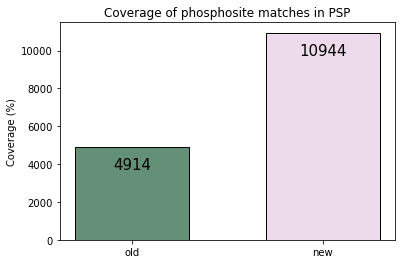

In [15]:
# plot coverage of phosphosite matches
n_old_cov = len(old_site_coverage)
n_new_cov = len(new_site_coverage)
n_all = len(new_df)

without_filtering = [n_old_cov, n_all-n_old_cov, (n_old_cov/n_all)*100, "old"]
with_canonical_filtering = [n_new_cov, n_all-n_new_cov, (n_new_cov/n_all)*100, "new"]

bar_df = pd.DataFrame([without_filtering, with_canonical_filtering], columns=["n_cov", "n_mis", "perc_cov", "type"])


colors = ["#639076", "#EDDAEB"]
plt.bar(bar_df["type"], bar_df["n_cov"], width = 0.6, color=colors, edgecolor = "black")
plt.title("Coverage of phosphosite matches in PSP")
plt.ylabel("Coverage (%)")
plt.text(bar_df["type"][0], bar_df["n_cov"][0] - n_all/10, bar_df["n_cov"][0], ha="center", size = 15)
plt.text(bar_df["type"][1], bar_df["n_cov"][1] - n_all/10, bar_df["n_cov"][1], ha="center", size = 15)
#plt.savefig("figures/coverage_phosphosite_matches.pdf")
plt.show()

### Evaluation of canonical filtering based on functional score 

In [16]:
# load raw phosphoproteomics datase without canonical filtering
old_df = pd.read_csv("data/wagner_data.txt", sep ="\t")

# create unique site ID with raw protein IDs and positions
old_df["Position"] = old_df["Position"].astype(str)
old_df["Position"] = old_df["Position"].str.split(".").str[0]
old_df["site_id"] = old_df["Protein"] + "_" + old_df["Amino acid"] + old_df["Position"]
old_df["site_id_short"] = old_df["Protein"] + "_" + old_df["Position"]

# map diseases to dataset without canonical filtering
map_funscore(old_df)
map_diseases(old_df)


,Protein,Position,Amino acid,Proteins,Positions,Protein names,Gene names,Localization probability,PEP,Score,...,Log2(HU/untreated replicate 2),Log2(ATRi + HU/untreated replicate 2),Log2(ATRi + HU/HU replicate 2),site_id,site_id_short,funscore,diseases_DISEASE,diseases_ALTERATION,diseases_PMIDs,diseases_NOTES
0,F8W708,149,S,F8W708;E7ERW0;E7EQU6;E7EWF5;A0A075B6E4;G5E9F4;...,149;145;149;149;149;154;155;118;149;155;90;65;69,Transcription cofactor vestigial-like protein 4,VGLL4,0.999925,4.270000e-42,225.700,...,-0.316079,-0.039562,0.211635,F8W708_S149,F8W708_149,NaN,NaN,NaN,NaN,NaN
1,F8W708,52,S,F8W708;E7ERW0;E7EQU6;E7EWF5;A0A075B6E4;G5E9F4;...,52;48;52;52;52;57;58;21;52;58;52,Transcription cofactor vestigial-like protein 4,VGLL4,0.816432,2.033800e-02,56.569,...,-2.021102,-2.066669,-0.039978,F8W708_S52,F8W708_52,NaN,NaN,NaN,NaN,NaN
2,A0A075B6E5,144,S,A0A075B6E5;Q8N8S7-3;Q8N8S7-2;Q8N8S7,144;125;125;125,Protein enabled homolog,ENAH,1.000000,1.300000e-18,140.570,...,0.326422,0.433707,-0.039296,A0A075B6E5_S144,A0A075B6E5_144,NaN,NaN,NaN,NaN,NaN
3,A0A075B6E5,755,S,A0A075B6E5;Q8N8S7-3;Q8N8S7-2,755;471;508,Protein enabled homolog,ENAH,0.999973,1.606230e-02,59.418,...,-0.269234,-0.243609,-0.102140,A0A075B6E5_S755,A0A075B6E5_755,NaN,NaN,NaN,NaN,NaN
4,K7EMY4,99,S,K7EMY4;A0A075B6E7;Q96GY3,99;182;182,Protein lin-37 homolog,LIN37,0.973697,3.660000e-32,160.430,...,-0.914739,-0.741469,0.162597,K7EMY4_S99,K7EMY4_99,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11636,Q9UPZ9-2,159,Y,Q9UPZ9-2;Q9UPZ9,159;159,Serine/threonine-protein kinase ICK,ICK,0.991339,6.220270e-04,74.141,...,-0.035697,0.440102,0.631803,Q9UPZ9-2_Y159,Q9UPZ9-2_159,NaN,NaN,NaN,NaN,NaN
11637,Q9Y2J2-2,342,Y,Q9Y2J2;Q9Y2J2-2;Q9Y2J2-4;Q9Y2J2-3,342;342;342;342,Band 4.1-like protein 3;Band 4.1-like protein ...,EPB41L3,1.000000,3.810830e-02,40.830,...,4.069015,4.112533,0.015640,Q9Y2J2-2_Y342,Q9Y2J2-2_342,NaN,NaN,NaN,NaN,NaN
11638,Q9Y2J2-2,348,Y,Q9Y2J2;Q9Y2J2-2;Q9Y2J2-4;Q9Y2J2-3,348;348;348;348,Band 4.1-like protein 3;Band 4.1-like protein ...,EPB41L3,1.000000,3.810830e-02,40.830,...,4.069015,4.112533,0.015640,Q9Y2J2-2_Y348,Q9Y2J2-2_348,NaN,NaN,NaN,NaN,NaN
11639,Q9Y3D6,93,Y,Q9Y3D6,93,Mitochondrial fission 1 protein,FIS1,1.000000,3.593710e-02,52.520,...,-4.405069,-5.697874,-1.288593,Q9Y3D6_Y93,Q9Y3D6_93,NaN,NaN,NaN,NaN,NaN


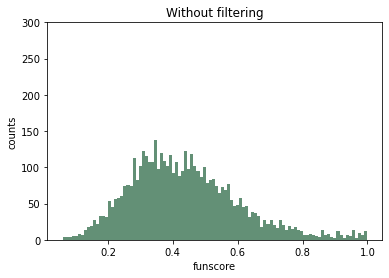

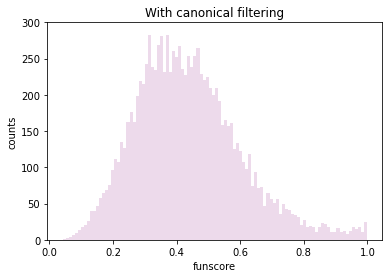

In [17]:
# Histograms illustrating the functional score before and after canonical filtering
plt.hist(old_df["funscore"], bins=100, color="#639076")
plt.ylim((0,300))
plt.xlabel("funscore")
plt.ylabel("counts")
plt.title("Without filtering")
#plt.savefig("figures/histogram_funscore_without_filt.pdf")
plt.show()


plt.hist(new_df["funscore"], bins=100, color="#EDDAEB")
plt.savefig("histogram_funscore_without_filt.pdf")
plt.ylim((0,300))
plt.xlabel("funscore")
plt.ylabel("counts")
plt.title("With canonical filtering")
#plt.savefig("figures/histogram_funscore_with_filt.pdf")
plt.show()

### Evaluation of canonical filtering based on disease annotations

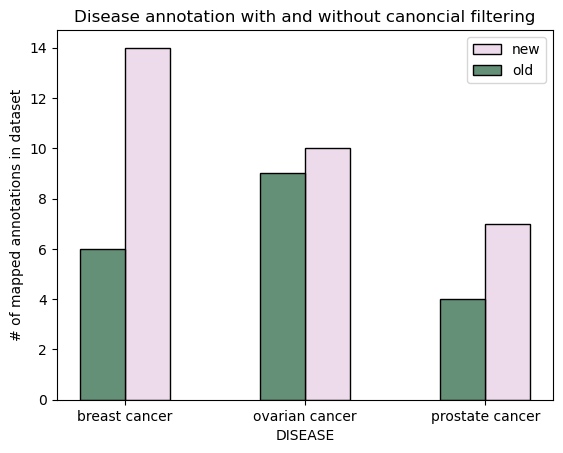

In [18]:
# count mapped entries for DISEASE annotation in dataset withouth canonical filtering
DISEASES_counts_old = old_df['diseases_DISEASE'].value_counts()
DISEASES_counts_old

# count mapped entries for DISEASE annotation in dataset with canonical filtering
DISEASES_counts = new_df['diseases_DISEASE'].value_counts()

# combine two series into a single dataframe (concatenation)
dc_df_all = pd.concat([DISEASES_counts, DISEASES_counts_old], axis=1)
dc_df_all.columns = ["disease_new", "disease_old"]
dc_df_all["DISEASE"] = dc_df_all.index
#dc_df_all.to_csv("data/disease_annotation_counts.txt", sep="\t")

# filter concatenated dataframe for subset of disease (as an example for illustration)
disease_list = ["breast cancer", "ovarian cancer", "prostate cancer"]
filt = dc_df_all.DISEASE.isin(disease_list)
dc_df = dc_df_all[filt]


# plot counts of mapped entries with and without canonical filtering
plt.style.use("default")
x = dc_df.index

# to make a "dodged" barplot with two groups, indices will be plotted on the x-axis
x_idx = np.arange(len(x))

# x-axis labels need to set manually in this case
labels = dc_df.index

# define width of bars
width = 0.25

# set the too subsets as seperate y-axis
y_new = dc_df.disease_new
y_old = dc_df.disease_old


plt.xticks(x_idx+0.5*width, labels)
plt.bar(x_idx+width, y_new, width=width, color="#EDDAEB", label="new", edgecolor = "black")
plt.bar(x_idx,  y_old,width=width, color="#639076", label="old", edgecolor = "black")
plt.legend()
plt.xlabel("DISEASE")
plt.ylabel("# of mapped annotations in dataset")
plt.title("Disease annotation with and without canoncial filtering")
#plt.savefig("figures/disease_annotation_without_filtering.pdf")
plt.show()

## Save filtered and annotated dataset as a new file

In [19]:
new_df.to_csv("data/wagner_data_canonical_IDs.txt", sep = "\t")